# CSE 158: Assignment 2

## This is an open-ended assignment in which you are expected to write a detailed report documenting your results. Please submit your solution electronically via gradescope, on or before Dec 3 (Tuesday week 10). This assignment is worth 25% of the final grade.

## Specify the names of all of your group members when submitting. Submissions should be in the form of a written report, which is expected to be at least four pages (double column, 11pt), or roughly 2.5-3 thousand words, plus figures, tables, and equations. See an example template in the lecture slides to get an idea of the length expected.

## Tasks

### 1. Identify a dataset to study, and perform an exploratory analysis of the data. Describe the dataset, including its basic statistics and properties, and report any interesting findings. This exploratory analysis should motivate the design of your model in the following sections. Datasets should be reasonably large (e.g. more than 50,000 samples).

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

from collections import defaultdict, namedtuple
import heapq

import csv
import numpy as np

from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import train_test_split

In [2]:
def IncrementToGame(inc : int):
    if inc < 10: return 'BLITZ'
    elif inc == 10: return 'RAPID'
    else: return 'CLASSICAL'

In [3]:
def MovesToNply(n : int, moves):
    return ' '.join(moves.strip().split(' ')[:n])

In [72]:
MovesToNply(100, "A3 B4 A3 C6 C7")

'A3 B4 A3 C6 C7'

In [4]:
class Game:
    def __init__(self, line):
        # Game ID
        self.id = line[0]
        
        # Whether game was rated or not
        self.rated = True if line[1] == 'TRUE' else False
        
        # Time of game creation and last move
        self.created_at = float(line[2])
        self.last_move_at = float(line[3])
        
        # Number of turns in game
        self.turns = int(line[4])
        
        # Game result: 'outoftime resign mate draw'
        self.victory_status = line[5]
        
        # Game winner: 'white black draw'
        self.winner = line[6]
        
        # Time increment, describes game timing in time+increment form
        self.increment_code = line[7]
        
        self.game_type = IncrementToGame(int(line[7].split('+')[0]))
        
        # ID and rating of white and black players
        self.white_id = line[8]
        self.white_rating = int(line[9])
        self.black_id = line[10]
        self.black_rating = int(line[11])
        
        # All game moves in standard chess notation
        self.moves = line[12]
        
        # Standardised code for opening
        self.opening_eco = line[13]
        
        # Opening name and number of moves in opening phase
        self.opening_name = line[14]
        self.opening_ply = int(line[15])
    
    def __repr__(self):
        return 'Game {}, rated {}, turns {}, status {}, winner {}, type {}'.format(self.id, self.rated,
                                                                                   self.turns, self.victory_status,
                                                                                   self.winner, self.game_type)

In [211]:
game_lens = [int(g.increment_code.split('+')[0]) for g in games]

In [231]:
set(g.victory_status for g in games)

{'mate', 'outoftime', 'resign'}

In [216]:
sum(1 for g in games if int(g.increment_code.split('+')[0]) < 10)

3895

(array([   30.,    54.,    57.,    65.,  1718.,   171.,   631.,   873.,
          253.,  9045.,    96.,   214.,    73.,    68.,  3212.,    43.,
           39.,    26.,   907.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20]),
 <a list of 19 Patch objects>)

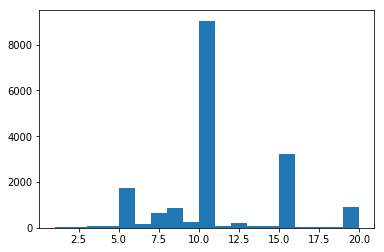

In [213]:
plt.hist(game_lens, bins=range(1,21))

In [6]:
def ParseCsv(filepath : str):
    with open(filepath) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader, None)
        for row in csv_reader:
            yield row

In [7]:
games = [Game(line) for line in ParseCsv('data/games.csv')]
games = [g for g in games if g.winner != 'draw']

In [51]:
openings = set(g.opening_eco for g in games)

In [52]:
len(openings)

365

In [8]:
uniqGames = set(g.id for g in games)

In [55]:
games[0].moves

'd4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5 Bf4'

In [56]:
plys = [g.opening_ply for g in games]

(array([    0.,  1097.,  2935.,  3490.,  3308.,  2730.,  2020.,  2460.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 8 Patch objects>)

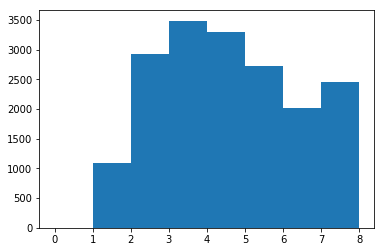

In [75]:
plt.hist(plys, bins=[0,1,2,3,4,5,6,7,8])

In [76]:
singlePlys = set(MovesToNply(1, g.moves) for g in games)

In [78]:
doublePlys = set(MovesToNply(2, g.moves) for g in games)

In [80]:
plyLens = [len(set(MovesToNply(i, g.moves) for g in games)) for i in range(1,6)]

In [81]:
plyLens

[20, 220, 1141, 2970, 5352]

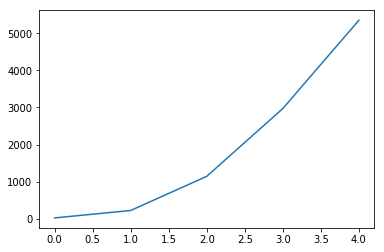

In [85]:
plt.plot(plyLens)

In [86]:
doublePlys

{'Na3 Nf6',
 'Na3 e5',
 'Nc3 Nc6',
 'Nc3 Nf6',
 'Nc3 Nh6',
 'Nc3 a6',
 'Nc3 b6',
 'Nc3 c5',
 'Nc3 c6',
 'Nc3 d5',
 'Nc3 d6',
 'Nc3 e5',
 'Nc3 e6',
 'Nc3 f5',
 'Nc3 g6',
 'Nf3',
 'Nf3 Na6',
 'Nf3 Nc6',
 'Nf3 Nf6',
 'Nf3 b5',
 'Nf3 b6',
 'Nf3 c5',
 'Nf3 c6',
 'Nf3 d5',
 'Nf3 d6',
 'Nf3 e5',
 'Nf3 e6',
 'Nf3 f5',
 'Nf3 f6',
 'Nf3 g6',
 'Nf3 h6',
 'Nh3 Na6',
 'Nh3 Nf6',
 'Nh3 d5',
 'Nh3 e5',
 'Nh3 e6',
 'a3 Nc6',
 'a3 b6',
 'a3 c6',
 'a3 d5',
 'a3 e5',
 'a3 g6',
 'a4 Nc6',
 'a4 Nf6',
 'a4 a5',
 'a4 a6',
 'a4 c5',
 'a4 d5',
 'a4 e5',
 'a4 e6',
 'a4 g5',
 'a4 g6',
 'b3 Nc6',
 'b3 Nf6',
 'b3 Nh6',
 'b3 a5',
 'b3 b6',
 'b3 c5',
 'b3 d5',
 'b3 d6',
 'b3 e5',
 'b3 e6',
 'b3 f5',
 'b3 f6',
 'b3 g6',
 'b4 Nc6',
 'b4 Nf6',
 'b4 a5',
 'b4 b5',
 'b4 b6',
 'b4 c5',
 'b4 c6',
 'b4 d5',
 'b4 d6',
 'b4 e5',
 'b4 e6',
 'b4 f5',
 'b4 f6',
 'b4 g6',
 'c3 Nf6',
 'c3 c5',
 'c3 d5',
 'c3 d6',
 'c3 e5',
 'c3 e6',
 'c3 g6',
 'c4 Nc6',
 'c4 Nf6',
 'c4 a5',
 'c4 a6',
 'c4 b5',
 'c4 b6',
 'c4 c5',
 'c4 c6',
 'c4 d5

In [89]:
plysIdx = {t[1]:t[0] for t in enumerate(doublePlys)}

In [90]:
plysIdx

{'Na3 Nf6': 147,
 'Na3 e5': 14,
 'Nc3 Nc6': 97,
 'Nc3 Nf6': 157,
 'Nc3 Nh6': 129,
 'Nc3 a6': 15,
 'Nc3 b6': 46,
 'Nc3 c5': 62,
 'Nc3 c6': 216,
 'Nc3 d5': 160,
 'Nc3 d6': 0,
 'Nc3 e5': 69,
 'Nc3 e6': 141,
 'Nc3 f5': 174,
 'Nc3 g6': 169,
 'Nf3': 88,
 'Nf3 Na6': 166,
 'Nf3 Nc6': 109,
 'Nf3 Nf6': 188,
 'Nf3 b5': 110,
 'Nf3 b6': 198,
 'Nf3 c5': 182,
 'Nf3 c6': 165,
 'Nf3 d5': 176,
 'Nf3 d6': 1,
 'Nf3 e5': 132,
 'Nf3 e6': 161,
 'Nf3 f5': 71,
 'Nf3 f6': 219,
 'Nf3 g6': 212,
 'Nf3 h6': 159,
 'Nh3 Na6': 112,
 'Nh3 Nf6': 94,
 'Nh3 d5': 63,
 'Nh3 e5': 50,
 'Nh3 e6': 149,
 'a3 Nc6': 51,
 'a3 b6': 61,
 'a3 c6': 196,
 'a3 d5': 70,
 'a3 e5': 44,
 'a3 g6': 78,
 'a4 Nc6': 102,
 'a4 Nf6': 12,
 'a4 a5': 124,
 'a4 a6': 39,
 'a4 c5': 134,
 'a4 d5': 36,
 'a4 e5': 74,
 'a4 e6': 17,
 'a4 g5': 77,
 'a4 g6': 215,
 'b3 Nc6': 66,
 'b3 Nf6': 218,
 'b3 Nh6': 3,
 'b3 a5': 48,
 'b3 b6': 101,
 'b3 c5': 82,
 'b3 d5': 72,
 'b3 d6': 158,
 'b3 e5': 154,
 'b3 e6': 59,
 'b3 f5': 2,
 'b3 f6': 206,
 'b3 g6': 136,
 'b4 Nc6': 1

In [91]:
doublePlyCounts = np.zeros(len(plysIdx))
for g in games:
    doublePlyCounts[plysIdx[MovesToNply(2, g.moves)]] += 1

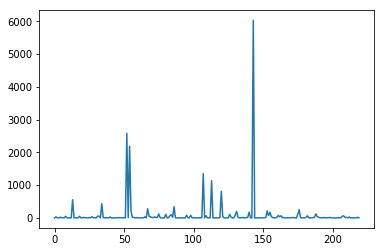

In [93]:
plt.plot(doublePlyCounts)

In [94]:
np.argmax(doublePlyCounts)

143

In [97]:
heapq.nlargest(5, enumerate(doublePlyCounts), key=lambda x: x[1])

[(143, 6029.0), (52, 2581.0), (54, 2185.0), (107, 1351.0), (113, 1138.0)]

In [103]:
def IdxToMoves(ind: int):
    for moves in plysIdx:
        if plysIdx[moves] == ind:
            return moves

In [104]:
IdxToMoves(143)

'e4 e5'

In [40]:
numDups = 0
allGames = defaultdict(int)
for g in games:
    allGames[g.id] += 1
    if allGames[g.id] > 1:
        numDups += 1
        print(g)

Game XRuQPSzH, rated False, turns 50, status resign, winner black, time 1503580000000.0
Game x1Svcl0P, rated False, turns 59, status mate, winner white, time 1499820000000.0
Game wgIHzqDo, rated False, turns 113, status mate, winner white, time 1499710000000.0
Game JrFxlGZo, rated False, turns 78, status mate, winner black, time 1489330000000.0
Game ezKACesj, rated False, turns 51, status mate, winner white, time 1488840000000.0
Game UVUUmRSQ, rated False, turns 56, status mate, winner black, time 1488730000000.0
Game de8kkad4, rated False, turns 2, status resign, winner white, time 1489010000000.0
Game yvqpdUQE, rated False, turns 26, status mate, winner black, time 1489010000000.0
Game dQCCZY4f, rated False, turns 12, status resign, winner white, time 1489010000000.0
Game 8zGwL053, rated False, turns 14, status resign, winner black, time 1489010000000.0
Game 2QYrX7bz, rated False, turns 73, status mate, winner white, time 1489010000000.0
Game QGXLgc6L, rated False, turns 3, status re

In [41]:
len(allGames)

19113

In [42]:
numDups + len(uniqGames)

20058

In [15]:
idRepeat = ''
for i,num in allGames.items():
    if num > 2:
        idRepeat = i
        break

In [43]:
idRepeat = 'eP09Yv7W'

In [25]:
len(games)

20058

In [44]:
for g in games:
    if g.id == idRepeat: print(g)

Game eP09Yv7W, rated False, turns 4, status mate, winner black, time 1500090000000.0
Game eP09Yv7W, rated False, turns 4, status mate, winner black, time 1500085220607.0
Game eP09Yv7W, rated False, turns 4, status mate, winner black, time 1500085220607.0


In [9]:
len(uniqGames)

19113

In [39]:
sum(1 for _ in ParseCsv('data/games.csv'))

20058

In [40]:
whiteUsers = set(l[8] for l in ParseCsv('data/games.csv'))

In [42]:
blackUsers = set(l[10] for l in ParseCsv('data/games.csv'))

In [41]:
len(whiteUsers)

9438

In [43]:
len(blackUsers)

9331

In [46]:
len(whiteUsers.union(blackUsers))

15635

### In the dataset there are 20,058 games with 15,635 unique players.

### 2. Identify a predictive task that can be studied on this dataset. Describe how you will evaluate your model at this predictive task, what relevant baselines can be used for comparison, and how you will assess the validity of your model’s predictions. It’s fine to use models that were described in class here (i.e., you don’t have to invent anything new (though you may!)), though you should explain and justify which model was appropriate for the task. It’s also important in this section to carefully describe what features you will use and how you had to process the data to obtain them.

In [39]:
def BaselineWinner(g):
    return 'white' if g.white_rating >= g.black_rating else 'black'

In [41]:
blitzes = defaultdict(int)
rapids = defaultdict(int)
classicals = defaultdict(int)
for g in games:
    if g.game_type == 'BLITZ': blitzes[g.victory_status] += 1
    elif g.game_type == 'RAPID': rapids[g.victory_status] += 1
    elif g.game_type == 'CLASSICAL': classicals[g.victory_status] += 1

In [42]:
blitzes

defaultdict(int, {'mate': 1254, 'outoftime': 419, 'resign': 2222})

In [43]:
rapids

defaultdict(int, {'mate': 3035, 'outoftime': 855, 'resign': 5155})

In [44]:
classicals

defaultdict(int, {'mate': 2036, 'outoftime': 362, 'resign': 3770})

In [45]:
def BaselineStatus(g):
    '''
    if g.game_type == 'BLITZ': return 'outoftime'
    elif g.game_type == 'RAPID': return 'mate'
    elif g.game_type == 'CLASSICAL': return 'resign'
    '''
    return 'resign'

In [46]:
nBRight, nBTotal = 0, len(games)
for g in games:
    if g.victory_status == 'resign': nBRight += 1

In [47]:
nBRight / nBTotal

0.5833682227339334

In [120]:
nDraws = sum(1 for g in games if g.winner == 'draw')

In [121]:
nDraws

950

In [122]:
nDrawsRated = sum(1 for g in games if g.winner == 'draw' and g.rated)

In [123]:
nDrawsUnrated = sum(1 for g in games if g.winner == 'draw' and not g.rated)

In [124]:
nDrawsRated, nDrawsUnrated

(317, 633)

In [134]:
nRated = sum(1 for g in games if g.rated and g.winner != 'draw')

In [135]:
nUnrated = sum(1 for g in games if not g.rated and g.winner != 'draw')

In [126]:
nRated

7432

In [197]:
nBulletRight, nBulletTotal = 0, sum(1 for g in games if g.game_type == 'BULLET')
for g in games:
    if g.game_type != 'BULLET': continue
    winner = 'white' if g.white_rating >= g.black_rating else 'black'
    if g.winner == winner: nBulletRight += 1

In [198]:
nBulletRight / nBulletTotal

0.6456692913385826

In [ ]:
nBlitzRight, nBlitzTotal = 0, sum(1 for g in games if g.game_type == 'BULLET')
for g in games:
    if g.game_type != 'BULLET': continue
    winner = 'white' if g.white_rating >= g.black_rating else 'black'
    if g.winner == winner: nBlitzRight += 1

In [12]:
def BaselineAccuracy(l):
    nRight, nTotal = 0, sum(1 for g in games if l(g))
    for g in games:
        if not l(g): continue
        winner = 'white' if g.white_rating >= g.black_rating else 'black'
        if g.winner == winner: nRight += 1
    return 0.0 if nRight == 0 else nRight / nTotal

In [223]:
BaselineAccuracy(lambda x : x.game_type == 'BLITZ')

0.6598202824133504

In [224]:
BaselineAccuracy(lambda x : x.game_type == 'RAPID')

0.6490878938640132

In [225]:
BaselineAccuracy(lambda x : x.game_type == 'CLASSICAL')

0.6494811932555123

In [229]:
BaselineAccuracy(lambda x : x.game_type == 'CLASSICAL' and not x.rated)

0.6464719753310357

In [207]:
nBullet = sum(1 for g in games if g.game_type == 'BULLET')

In [208]:
nBullet

127

In [209]:
sum(1 for g in games if g.game_type == 'BLITZ')

12813

In [210]:
sum(1 for g in games if g.game_type == 'RAPID')

6168

### Our baseline for comparison is predicting that the player with the higher rating will win. We ignore cases where the game ended in a draw. With this baseline we get an accuracy of 65.1% on the entire dataset, which is our accuracy to beat. For rated games the baseline has a 64.6% accuracy and for unrated games a 65.5% accuracy, or about 0.9 percentage points higher for unrated games.

|Baseline|Accuracy|
|--------|--------|
|Overall |0.651   |
|Rated   |0.646   |
|Unrated |0.655   |
|Bullet  |0.646   |
|Blitz   |0.652   |
|Rapid   |0.649   |

### 3. Describe your model. Explain and justify your decision to use the model you proposed. How will you optimize it? Did you run into any issues due to scalability, overfitting, etc.? What other models did you consider for comparison? What were your unsuccessful attempts along the way? What are the strengths and weaknesses of the different models being compared?

In [141]:
# [1 rating_difference] 1 for white won, 0 for black won

In [32]:
X = [[1, g.white_rating, g.black_rating,
      1 if g.victory_status == 'outoftime' else 0,
      1 if g.victory_status == 'resign' else 0,
      1 if g.victory_status == 'mate' else 0] for g in games]
y = [1 if g.winner == 'white' else 0 for g in games]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [34]:
def RegPipeline(cs):
    accsTrain = []
    accsTest = []
    for c in cs:
        clf = linear_model.LogisticRegression(C=c) # svm.SVC(C=c)
        clf.fit(X_train, y_train)
        accTrain = ClfAccuracy(X_train, y_train, clf)
        accTest = ClfAccuracy(X_test, y_test, clf)
        accsTrain.append(accTrain)
        accsTest.append(accTest)
    return accsTrain, accsTest

In [35]:
accsTrSimple, accsTeSimple = RegPipeline([10**-i for i in range(-6,4)])

In [36]:
accsTrSimple, accsTeSimple

([0.65412571960225618,
  0.65412571960225618,
  0.65412571960225618,
  0.65412571960225618,
  0.65412571960225618,
  0.65412571960225618,
  0.65406756992498694,
  0.65476536605221836,
  0.65430016863406404,
  0.65441646798860265],
 [0.63369963369963367,
  0.63369963369963367,
  0.63369963369963367,
  0.63369963369963367,
  0.63369963369963367,
  0.63369963369963367,
  0.63369963369963367,
  0.63317634746206175,
  0.6342229199372057,
  0.63369963369963367])

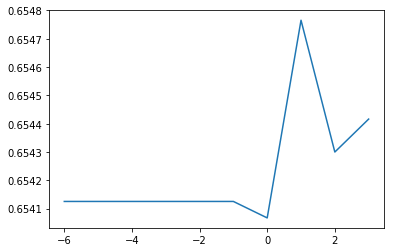

In [37]:
xs = list(range(-6,4))
plt.plot(xs, accsTrSimple)

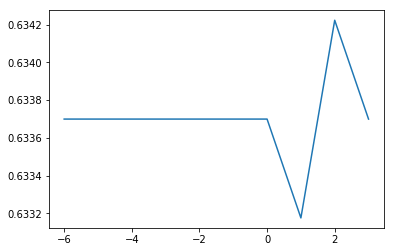

In [38]:
plt.plot(xs, accsTeSimple)

In [168]:
accs = RegPipeline([10**i for i in range(-3,4)])

In [192]:
accsTr1, accsTe1 = RegPipeline([10**i for i in np.arange(-1.5, 0.0, 0.1)])

In [182]:
accs2 = RegPipeline([10**i for i in np.arange(-1.0, 0.0, 0.1)])

In [179]:
accs

[0.60319042871385842,
 0.61116650049850452,
 0.61415752741774676,
 0.61565304087736794,
 0.61665004985044869,
 0.61565304087736794,
 0.61415752741774676,
 0.61365902293120633,
 0.61415752741774676,
 0.61465603190428719]

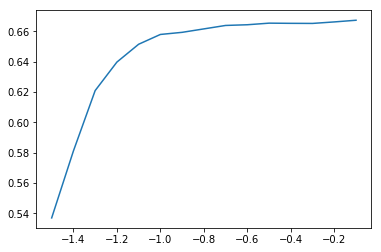

In [193]:
xs = np.arange(-1.5, 0.0, 0.1)
plt.plot(xs, accsTr1)

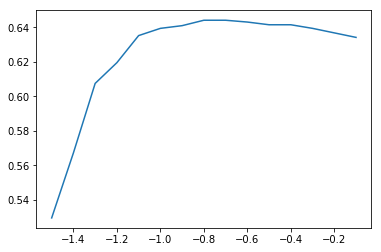

In [194]:
plt.plot(xs, accsTe1)

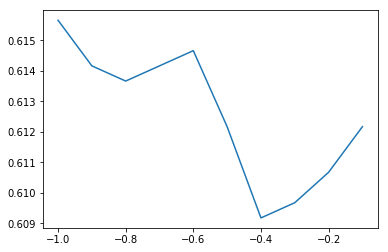

In [183]:
xs2 = np.arange(-1.0, 0.0, 0.1)
plt.plot(xs2, accs2)

In [158]:
clfFirst = svm.SVC()
clfFirst.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
def ClfAccuracy(X, y, clf):
    ps = clf.predict(X)
    return sum(np.array(ps) == np.array(y)) / len(y)

In [159]:
ClfAccuracy(X_train, y_train, clfFirst)

0.66297363173055612

In [160]:
ClfAccuracy(X_test, y_test, clfFirst)

0.61216350947158527

### 4. Describe literature related to the problem you are studying. If you are using an existing dataset, where did it come from and how was it used? What other similar datasets have been studied in the past and how? What are the state-of-the-art methods currently employed to study this type of data? Are the conclusions from existing work similar to or different from your own findings?

### 5. Describe your results and conclusions. How well does your model perform compared to alternatives, and what is the significance of the results? Which feature representations worked well and which do not? What is the interpretation of your model’s parameters? Why did the proposed model succeed why others failed (or if it failed, why did it fail)?